### PCA-Nets for solving a Stokes Problem.

In this example we want to use the PCA-Net approach to solve the Stokes equation on a square for varying inflow 
profiles.

We have the domain $\Omega = (0,1)\times(0,1)$. Our PDE is of the following form:

\begin{align*}
    \mu \Delta u - \nabla p &= 0 &&\text{ in } \Omega, \\
    \text{div}(u) &= 0 &&\text{ in } \Omega, \\
    u &= f &&\text{ on } \partial \Omega \cap \{x_2=1\}, \\
    u &= 0 &&\text{ on } \partial \Omega \cap \{x_2\neq1\}.
\end{align*}

In the Stokes equation we have two unkowns, the velocity $u$ (which is vector valued!) and pressure $p$. In this example we will only try to predict $u$. Our boundary conditions mean, that at the top of the square $\Omega$ we describe an inflow profile $f$, while on all other boundaries we set the velocity to 0.

In [ ]:
# This block is for GPU selection. Please execute.
import pathlib
import os
user = int(str(pathlib.Path().resolve())[22:24])
os.environ["CUDA_VISIBLE_DEVICES"]= str(user % 4)

import torch 
import torchphysics as tp
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

Start with loading the data:

In [9]:
input_data = torch.load("/localdata/komso/datasets/PCA_data_Stokes/stokes_input.pt")
output_data = torch.load("/localdata/komso/datasets/PCA_data_Stokes/stokes_output.pt")

print("Available data points:", len(input_data))
print("Shape of input data:", input_data.shape)
print("Shape of output data:", output_data.shape)

Available data points: 20000
Shape of input data: torch.Size([20000, 64, 2])
Shape of output data: torch.Size([20000, 64, 64, 2])


Plot one example data:

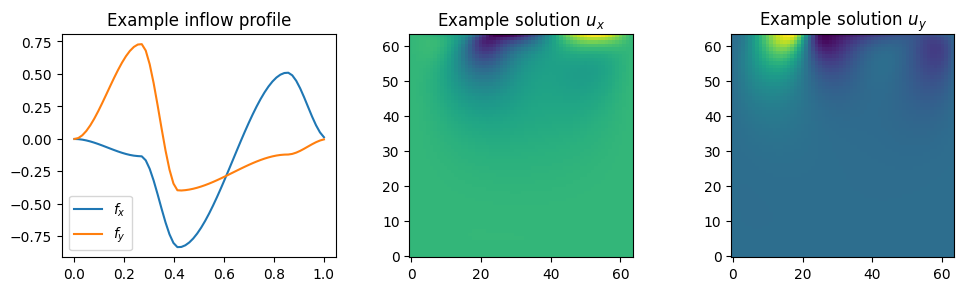

In [ ]:
plot_idx = 0


f, axarr = plt.subplots(1, 3, figsize=(10, 3))
axarr[0].plot(np.linspace(0, 1, input_data.shape[1]), input_data[plot_idx, :, 0])
axarr[0].plot(np.linspace(0, 1, input_data.shape[1]), input_data[plot_idx, :, 1])
axarr[0].legend([r"$f_x$", r"$f_y$"])
axarr[0].title.set_text(r"Example inflow profile")
axarr[1].imshow(output_data[plot_idx, :, :, 0], origin='lower')
axarr[1].title.set_text(r"Example solution $u_x$")
axarr[2].imshow(output_data[plot_idx, :, :, 1], origin='lower')
axarr[2].title.set_text(r"Example solution $u_y$")
plt.tight_layout()

Create spaces for the variables and functions.

In [ ]:
X = tp.spaces.R1("x")
Y = tp.spaces.R1("y")
F = tp.spaces.R2("f") # TODO: Create a two-dimensional space for the input f
U = tp.spaces.R2("u") # TODO: Create a two-dimensional space for the output u

fn_space_input = tp.spaces.FunctionSpace(X, F) # TODO: Build functionspace for input functions X->F
fn_space_output = tp.spaces.FunctionSpace(X*Y, U) # TODO: Build functionspace for output functions X*Y->U

Build datasets and samplers:

In [ ]:
# Split data into training and testing:
total_data = len(input_data)
train_N = int(0.8*total_data) # we use 80% of the data for training

train_input = input_data[:train_N]
train_output = output_data[:train_N]

test_input = input_data[train_N:]
test_output = output_data[train_N:]

# TODO: Implement the "tp.domains.DataFunctionSet" for the input and output data.
data_functionset_input = tp.domains.DataFunctionSet(fn_space_input, input_data)
data_functionset_output = tp.domains.DataFunctionSet(fn_space_output, output_data)

# TODO: Finish the FunctionSamplers for the data.
functionsampler_input = tp.samplers.FunctionSamplerRandomUniform(10000, data_functionset_input)
functionsampler_output = tp.samplers.FunctionSamplerCoupled(data_functionset_output, functionsampler_input)

As before we now need to compute the pca on our data:

In [ ]:
# TODO: Compute the PCA on the input dataset and output dataset.
# Use 60 PCs for the input functions f, and 100 PCs for u
data_functionset_input.compute_pca(components=60)  
data_functionset_output.compute_pca(components=100)

# Then we define the PCA-Net:
# TODO: Add the functionspaces and set the architecture to two hidden layers with 100 neurons each:
model = tp.models.PCANN_FC.from_fn_set(
    data_functionset_input, data_functionset_output, hidden=(100, 100)
)

Next, we define the condition which describes that the model should learn to map the input $f$ to the output $u$.

In [ ]:
# TODO: Finish the input arguments:
data_condition = tp.conditions.OperatorCondition(module=model, 
                                                 input_function_sampler=functionsampler_input, 
                                                 output_function_sampler=functionsampler_output)

We are done and can start the training:

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.StepLR

optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001,
                            scheduler_class=lr_scheduler, 
                            scheduler_args={"step_size": 3000, "gamma":0.25})
solver = tp.solver.Solver([data_condition], optimizer_setting=optim)

from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme
trainer = pl.Trainer(devices=1, accelerator="gpu",
                    num_sanity_val_steps=0,
                    benchmark=True,
                    max_steps=15000, 
                    callbacks=[RichProgressBar(theme=RichProgressBarTheme(metrics= "black", metrics_format='.7f'))], # show training process
                    logger=False, 
                    enable_checkpointing=False)

trainer.fit(solver)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/tomfre/miniconda3/envs/tp_version2/lib/python3.11/site-packages/pytorch_lightning/core/optimizer.py:256: Found unsupported keys in the lr scheduler dict: {'step_size', 'gamma'}. HINT: remove them from the output of `configure_optimizers`.

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 26.3 K
1 | val_conditions   | ModuleList | 0     
-----------

Epoch 0: 100%|██████████| 15000/15000 [03:17<00:00, 76.10it/s, train/loss=9.09e-5] 

`Trainer.fit` stopped: `max_steps=15000` reached.


Epoch 0: 100%|██████████| 15000/15000 [03:17<00:00, 76.10it/s, train/loss=9.09e-5]


Evaluate on unseen data:

In [ ]:
model_output = model(tp.spaces.Points(test_input, F)).as_tensor.detach()

rel_error = torch.max(torch.abs(model_output - test_output)) / torch.max(test_output)

print(f"Relative error: {rel_error*100} %")


Relative error: 7.563377857208252 %


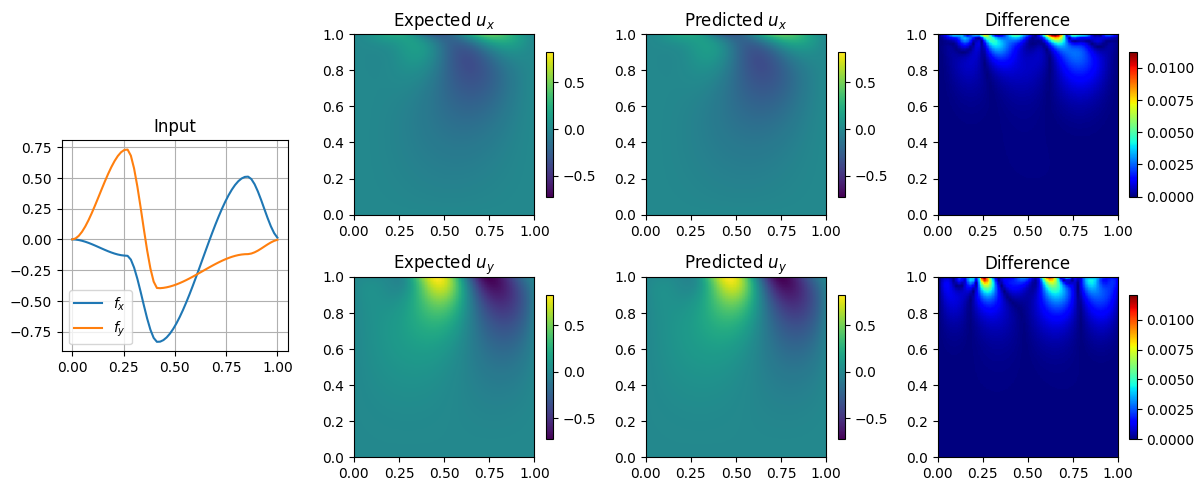

In [43]:
plot_idx = 0

sol_min = torch.min(test_output[plot_idx])
sol_max = torch.max(test_output[plot_idx])

# Plot 
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(2, 4)

# First column: just plot the input
ax_big = fig.add_subplot(gs[:, 0]) 
ax_big.set_aspect(0.6) 
ax_big.plot(np.linspace(0, 1, train_input.shape[1]), train_input[plot_idx, :, 0])
ax_big.plot(np.linspace(0, 1, train_input.shape[1]), train_input[plot_idx, :, 1])
ax_big.set_title("Input")
ax_big.grid()
ax_big.legend([r"$f_x$", r"$f_y$"])

# Remaining subplots (2 rows x 3 columns)
plot_data = [test_output[plot_idx], 
             model_output[plot_idx], 
             torch.abs(test_output[plot_idx] - model_output[plot_idx])]
title = [[r"Expected $u_x$", r"Predicted $u_x$", r"Difference"], 
         [r"Expected $u_y$", r"Predicted $u_y$", r"Difference"]]
for r in range(2):
    for c in range(1, 4):
        ax = fig.add_subplot(gs[r, c])
        if c < 3:
            img = ax.imshow(plot_data[c-1][:, :, r], extent=[0,1,0,1],
                            vmin=sol_min, vmax=sol_max, origin='lower')
        else:
            img = ax.imshow(plot_data[c-1][:, :, r], extent=[0,1,0,1], cmap='jet', origin='lower')
        plt.colorbar(img, ax=ax, shrink=0.75)
        ax.set_title(title[r][c-1])

plt.tight_layout()